# Truncated distributions

This tutorial will cover how to implement your own
truncated distribution in numpyro.
It is assumed that you're already familiar with the basics of Numpyro.
To get the most out of this tutorial, you'll need some background in probability.

**Contents**
1. What is a truncated distribution
2. How to sample from a truncated distribution
3. Recap of numpyro distributions
4. Building your own trucanted distributions
    4.1 Right-truncated normal
    4.2 Left-truncated Poisson
5. Ready-to-use truncated distributions availale in Numpyro.

**To do**:
* Add links


## What is a truncated distrubution?

The _support_ of a probability distribution is the set of values
in the domain with non-zero probability. For example, the
support of the Normal distribution is the whole real line (even if
the density gets very small as we move away from the mean, technically
speaking, it is never quite zero). The support of the uniform distribution,
as coded in `jax.random.uniform` with the default arguments, is the interval $\left[0, 1)\right.$, because any
value outside of that interval has zero probability. The support of the Poisson distribution is the set of non-negative integers. Etc.

_Truncating_ a distribution is the process of modifying the support of the distribution
so that any value outside our desired domain has zero probability. In practice, this can be useful
for modelling situations in which certain biases are introduced during data collection.
For example, some physical detectors only get triggered when the signal is above some
minimal threshold, or sometimes the detectors fail if the signal exceeds a certain value.
As a result, the _observed_ values are constrained to be within a limited range of values, even though the true signal does not have the same constraints.
See, for example, section 3.1 of _Information Theory and Learning Algorithms_ by David Mackay.
Naively, if $S$ is the support of the original density $p_Y(y)$, then by truncating the support
to a new support $T\subset S$ we are effectively defining a new random variable $Z$ for which
the density is

\begin{equation}
  p_Z(z) \propto
    \begin{cases}
      p_Y(z) & \text{if $z$ is in $T$}\\
      0 & \text{if $z$ is outside $T$}\\
    \end{cases}       
\end{equation}

The reason for writing a $\propto$ (proportional to) sign instead of strict equation is that,
defined in the above way, the resulting function does not integrate to $1$ and so it cannot be strictly considered a probability density. In order to make it into a probabilty density we need to re-distribute the truncated mass
among the part of the distribution that remains. To do this, we simply re-weight every point by the same constant:

\begin{equation}
  p_Z(z) =
    \begin{cases}
      \frac{1}{M}p_Y(z) & \text{if $z$ is in $T$}\\
      0 & \text{if $z$ is outside $T$}\\
    \end{cases}       
\end{equation}

where $M = \int_T p_Y(y)\mathrm{d}y$. Typically, the truncation is "one-sided". This means that if, for example, the support before truncation is the interval $(a, b)$, then the support after truncation is of the form $(a, c)$ or $(c, b)$, with $a < c < b$. The figure below illustrates a right-sided truncation.

<img src="https://i.ibb.co/x2fhd0y/truncated-normal.png" alt="drawing" width="900"/>

The original distribution (left side) is truncated at the vertical dotted line. The truncated mass (orange region) is redistributed in the new support (right side) so that the total area under the curve remains equal to 1 even after truncation. Though there could be other forms of re-weighting the truncated distribution, this method
ensures that the density ratio between any two points, $p(a)/p(b)$ remains the same before and after
the reweighting is done (as long as the points are inside the new support, of course).

**Note**: Truncated data is different from _censored_ data. Censoring also hides values that are outside some desired support but, contrary to truncated data, we know when a value has been censored. The typical example is the household scale which does not report values above 300 pounds. Censored data will not be covered in this tutorial.

## Sampling from a truncated distribution

Usually we already have a sampler for the the pre-truncated distribution (e.g np.random.normal).
So, a seemingly simple way of generating samples from the truncated distribution would be to
sample from the original distribution, and then discard the samples that are outside the 
desired support. For example, if we wanted samples from a normal distribution truncated to the
support $(-\infty, 1)$, we'd simply do:

```python
upper = 1
samples = np.random.normal(size=1000)
truncated_samples = samples[samples < upper]
```

The problem with this approach is efficiency. If the region we truncated had suffiently high probability mass,
then we might be discarding a lot of samples and it might be a while before we accumulate sufficient samples
for the truncated distribution.
A more efficient approach is to use a method known as [inverse transforms sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling).
In this method we first sample from a uniform distribution in (0, 1) and then transform those samples with the inverse cumulative distribution of our truncated distribution.
This method ensures that no samples are wasted in the process, though it does have the slight complication that
that we need to be able to calculate the inverse CDF (ICDF) of our truncated distribution. This might sound too complicated at first, but with a bit of algebra we can often calculate the truncated ICDF in terms of the untruncated ICDF. The untruncated ICDF for many distributions is already available.

Before we move on to the examples, let's quickly recap the basic ingredients of a Numpyro distribution.

## Quick recap of Numpyro distributions.

A Numpyro distribution should subclass `Distribution` and implement a few basic ingredients:

**Class attributes:**
The class attributes serve a few different purposes. The two most important are:
1. `arg_constraints`: Impose some requirements on the parameters of the distribution. Raise error at instantiation time if the parameters passed do not satisfy the constraints.
2. `support`: is used in some inference algorithms like MCMC, SVI with autoguides, where we need to perform the algorithm in the unconstrained space. Knowing the support, we can automatically reparametrize things under the hood.
We'll explain other class attributes as we go.

**The `__init__` method:**
This is where we define the parameters of the distribution.
We also use `jax` and `lax` to promote the parameters to shapes that are valid for broadcasting.
The `__init__` method of the parent class is also required because that's where the validation of our parameters is done.

**The `log_prob` method:**
Implementing the `log_prob` method ensures that we can do inference. As the name suggests, this method returns the logarithm of the density evaluated at the argument.


**The `sample` method:**
This method is used for drawing independent samples from our distribution. It is particularly useful for doing prior checks.


The place-holder code for any of our implementations can be written as
```python
class MyDistribution(Distribution):
    # class attributes
    arg_constraints = {}
    support = None
    def __init__(self):
        pass
    
    def log_prob(self, value):
        pass
    
    def sample(self, key, sample_shape=()):
        pass
```

## Examples
Let's now move on to concrete examples. Here's the ingredients we need to import:

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import lax, random
from jax.scipy.special import ndtr, ndtri
from jax.scipy.stats import poisson, norm
from numpyro.distributions import Distribution, constraints
from numpyro.distributions.util import promote_shapes
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, Predictive

numpyro.set_host_device_count(4)
numpyro.enable_x64(True)
RNG = random.PRNGKey(0)

/Users/omarfsosa/.pyenv/versions/3.8.10/envs/numpyro/lib/python3.8/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


### Example: Right-truncated normal

We are going to modify a normal distribution so that its new support is
of the form `(-inf, high)`, with `high` a finite real number. A (non-truncated)
normal distribution is usually specified in Numpyro by 2 parameters `loc` and `scale`
which correspond to the mean and standard deviation.

We'll call our distribution `RightTruncatedNormal`. Let's write the skeleton code and then proceed to fill in the blanks.

```python
class RightTruncatedNormal(Distribution):
    # <class attributes>
    def __init__(self):
        pass
    
    def log_prob(self, value):
        pass
    
    def sample(self, key, sample_shape=()):
        pass
```
    

#### Class attributes
Looking at the [source code](https://github.com/pyro-ppl/numpyro/blob/0664c2d2dd1eb5f41ea6a0bcef91e5fa2a417ce5/numpyro/distributions/continuous.py#L1337) for the `Normal` distrbution we see the following lines:
```python
arg_constraints = {"loc": constraints.real, "scale": constraints.positive}
support = constraints.real
reparametrized_params = ["loc", "scale"]
```
The `reparametrized_params` is used to determine if a distribution is reparameterizable. Reparametrizing is used to deal with complicated posterior geometries that make sampling very slow or biased. See [this tutorial](https://pyro.ai/examples/svi_part_iii.html#Tricky-Case:-Non-reparameterizable-Random-Variables) if you're interested.


We must adapt these attributes to our case by including the `"high"` parameter.
However, the `support` can no longer be a class attribute as it will depend on the value of `high`.
So instead we implement it as a property. Our distribution then looks as follows:
```python
class RightTruncatedNormal(Distribution):
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "high": constraints.real,
    }
    reparametrized_params = ["loc", "scale", "high"]
    
    # ...
    
    @constraints.dependent_property
    def support(self):
        return constraints.lower_than(self.high)
```

**To do:**
* What's the advantage of using `constraints.dependent_property` over a simple `property`?

#### The `__init__` method
Once again we take inspiration from the [source code](https://github.com/pyro-ppl/numpyro/blob/0664c2d2dd1eb5f41ea6a0bcef91e5fa2a417ce5/numpyro/distributions/continuous.py#L1342) for the normal distribution. The key point is the use of `lax` and `jax` to check the shapes of the arguments passed and make sure that such shapes are consistent for broadcasting. We follow the same pattern for our use case -- all we need to do is include the `high` parameter.
```python
# ...
    def __init__(self, loc=0.0, scale=1.0, high=float("inf"), validate_args=None):
        batch_shape = lax.broadcast_shapes(
            jnp.shape(loc),
            jnp.shape(scale),
            jnp.shape(high),
        )
        self.loc, self.scale, self.high = promote_shapes(loc, scale, high)
        super().__init__(batch_shape, validate_args=validate_args)
# ...
```

**To do**:
* Explain the default value for the `high` parameter.

#### The `log_prob` method
For a truncated distribution, the log density is given by

\begin{equation}
  \log p_Z(z) =
    \begin{cases}
      \log p_Y(z) - \log M & \text{if $z$ is in $T$}\\
      -\infty & \text{if $z$ is outside $T$}\\
    \end{cases}       
\end{equation}

where, again, $p_Z$ is the density of the truncated distribution, $p_Y$ is the density before truncation, and $M = \int_T p_Y(y)\mathrm{d}y$. For the specific case of truncating the normal distribution to the interval `(-inf, high)`, the constant $M$ is equal to the cumulative density evaluated at the truncation point. We can easily implement this log-density method because `jax.scipy.stats` already has a `norm` module that we can use.

```python
# ...
    def log_prob(self, value):
        log_m = norm.logcdf(self.high, self.loc, self.scale)
        log_p = norm.logpdf(value, self.loc, self.scale)
        return jnp.where(value < self.high, log_p - log_m, -jnp.inf)
# ...
```

#### The `sample` method

To implement the sample method using inverse transform sampling we need to also implement the inverse cumulative distribution function. For this we can also use the `ndtri` function that lives inside `jax.scipy.special`. This function returns the inverse cdf for the standard normal distribution, but we can do a bit of algebra to obtain the inverse cdf of the truncated, non-standard normal. First recall that if $X\sim Normal(0, 1)$ and $Y = \mu + \sigma X$, then $Y\sim Normal(\mu, \sigma)$. Then if $Z$ is the truncated $Y$, its cumulative density is given by:

\begin{align}
F_Z(y) &= \int_{-\infty}^{y}p_Z(r)dr\newline
       &= \frac{1}{M}\int_{-\infty}^{y}p_Y(s)ds \quad\text{if $y < high$} \newline
       &= \frac{1}{M}F_Y(y)
\end{align}

And so its inverse is

\begin{align}
F_Z^{-1}(u) = \left(\frac{1}{M}F_Y\right)^{-1}(u)
            = F_Y^{-1}(M u)
            = F_{\mu + \sigma X}^{-1}(Mu)
            = \mu + \sigma F_X^{-1}(Mu)
\end{align}

And the translation to code is

```python
# ...
    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        minval = jnp.finfo(jnp.result_type(float)).tiny
        u = random.uniform(key, shape, minval=minval)
        return self.icdf(u)


    def icdf(self, u):
        m = norm.cdf(self.high, self.loc, self.scale)
        return self.loc + self.scale * ndtri(m * u)
```

With everything in place, the final implementation is as below:

In [2]:
ALMOST_1 = 1.0 - jnp.finfo(jnp.result_type(float)).eps

In [4]:
class RightTruncatedNormal(Distribution):
    """
    A truncated Normal distribution.
    :param numpy.ndarray loc: location parameter of the untruncated normal
    :param numpy.ndarray scale: scale parameter of the untruncated normal
    :param numpy.ndarray high: point at which the truncation happens
    """
    arg_constraints = {
        "loc": constraints.real,
        "scale": constraints.positive,
        "high": constraints.real,
    }
    reparametrized_params = ["loc", "scale", "high"]
    
    def __init__(self, loc=0.0, scale=1.0, high=None, validate_args=True):
        if high is None:
            # Cannot use `inf` as high due to validation
            # But we default to a very high value which is just as good.
            high = loc + scale * ndtri(ALMOST_1)
            
        batch_shape = lax.broadcast_shapes(
            jnp.shape(loc),
            jnp.shape(scale),
            jnp.shape(high),
        )
        self.loc, self.scale, self.high = promote_shapes(loc, scale, high)
        super().__init__(batch_shape, validate_args=validate_args)
    
    def log_prob(self, value):
        log_m = norm.logcdf(self.high, self.loc, self.scale)
        log_p = norm.logpdf(value, self.loc, self.scale)
        return jnp.where(value < self.high, log_p - log_m, -jnp.inf)
    
    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        minval = jnp.finfo(jnp.result_type(float)).tiny
        u = random.uniform(key, shape, minval=minval)
        return self.icdf(u)

    def icdf(self, u):
        m = norm.cdf(self.high, self.loc, self.scale)
        return self.loc + self.scale * ndtri(m * u)
    
    @constraints.dependent_property
    def support(self):
        return constraints.less_than(self.high)

Let's try it out!

In [5]:
def truncated_normal_model(num_observations, x=None):
    loc = numpyro.sample("loc", dist.Normal())
    scale = numpyro.sample("scale", dist.LogNormal())
    high = numpyro.sample("high", dist.Normal())
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x", RightTruncatedNormal(loc, scale, high), obs=x)

In [6]:
num_observations = 250
prior = Predictive(truncated_normal_model, num_samples=num_observations)
prior_samples = prior(RNG, num_observations)

In [7]:
true_loc, true_scale, true_high = (prior_samples[param][0] for param in ['loc', 'scale', 'high'])
true_x = prior_samples['x'][0]

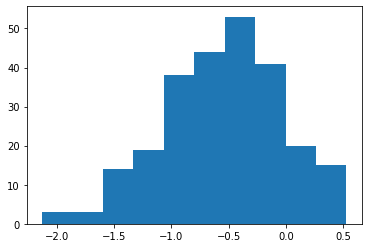

In [8]:
plt.hist(true_x);

In [9]:
mcmc = MCMC(NUTS(truncated_normal_model), num_warmup=4_000, num_samples=4000, num_chains=4)
mcmc.run(RNG, num_observations, true_x)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [10]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      high      0.61      0.19      0.56      0.53      0.68    431.09      1.00
       loc     -0.52      0.04     -0.52     -0.58     -0.46    197.37      1.01
     scale      0.55      0.03      0.54      0.49      0.60     96.67      1.03

Number of divergences: 14453


In [11]:
true_high, true_loc, true_scale, 

(DeviceArray(0.60420969, dtype=float64),
 DeviceArray(-0.52314339, dtype=float64),
 DeviceArray(0.57130916, dtype=float64))

Note that, even though we are able to correctly recover the true values,
we had a very high number of divergences. These divergences happen because
the log-density of our truncated distribution is not smooth and the NUTS
algorithm relies on the differentiability of the posterior. If you need to
infer the truncation point, make sure to be extra careful and do additional
checks on your inferences.

The results are more reliable when the truncation point is already known:

In [12]:
model_known_high = numpyro.handlers.condition(truncated_normal_model, {"high": true_high})

In [13]:
mcmc = MCMC(NUTS(model_known_high), num_warmup=4_000, num_samples=4000, num_chains=4)
mcmc.run(RNG, num_observations, true_x)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [14]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       loc     -0.52      0.04     -0.52     -0.59     -0.46  10017.90      1.00
     scale      0.54      0.03      0.54      0.50      0.59  10647.11      1.00

Number of divergences: 0


### Example: Left-truncated Poisson

To complete this tutorial, we implement a left-truncated Poisson distribution
(note that a right-truncated Poisson distribution could be reformulated as a particular
case of a categorical distribution).

#### Class attributes.
For a truncated Poisson we need two parameters, the `rate` of the original Poisson
distribution and a `low` parameter to indicate the point at which the distribution is truncated.
As this is a discrete distribution, we need to clarify whether or not the truncation point is included
in the support. In this tutorial, we'll take the convention that the truncation point `low`
_is_ part of the support.

The `low` parameter has to be given a 'non-negative integer' constraint. As it is a discrete parameter, it will not be possible to do inference for this parameter using `NUTS`. This is likely not a problem since the truncation point is often obvious. However, if we really must infer the `low` parameter, then it is possible to do so with `DiscreteHMCGibbs` though one is limited to using priors with enumerate support.

Like in the case of the truncated normal, the support of this distribution will be defined as a property and not as a class attribute because it depends on the specific value of the `low` parameter.
```python
class LeftTruncatedPoisson:
    arg_constraints = {
        "low": constraints.nonnegative_integer,
        "rate": constraints.positive,
    }
    
    # ... 
    @constraints.dependent_property(is_discrete=True, event_dim=0)
    def support(self):
        return constraints.integer_greater_than(self.low - 1)
```

#### The `__init__` method
This is simple, we just follow the same pattern as in the previous example.
```python
    # ...
    def __init__(self, rate=1.0, low=0, validate_args=None):
        batch_shape = lax.broadcast_shapes(
            jnp.shape(low), jnp.shape(rate)
        )
        self.low, self.rate = promote_shapes(low, rate)
        super().__init__(batch_shape, validate_args=validate_args)
    # ...
```


#### The `log_prob` method
The logic is very similar to the truncated normal case. The only thing we have to be careful of is to normalize using the correct constant. This time are truncating on the left so the correct normalization is the complementary cumulative density. We can also rely on the `poisson` module that lives inside `jax.scipy.stats`.

```python
    # ...
    def log_prob(self, value):
        m = 1 - poisson.cdf(self.low - 1, self.rate)
        log_p = poisson.logpmf(value, self.rate)
        return jnp.where(value >= self.low, log_p - jnp.log(m), -jnp.inf)
    # ...
```
#### The `sample` method.
Inverse-transform sampling also works for discrete distributions. The "inverse" cdf of a discrete distribution being defined as:

\begin{align}
F^{-1}(u) = \max\left\{n\in \mathbb{N} \rvert F(n) \lt u\right\}
\end{align}

Or, in plain English, $F^{-1}(u)$ is the highest number for which the cumulative density is less than $u$.
However, there's currently no implementation of $F^{-1}$ for the Poisson distribution in Jax (at least, at the moment of writing this tutorial). We have to rely on our own implementation of the `icdf` for the Poisson distribution. Fortunately, we can take advantage of the discrete nature of the distribution and easily implement a "brute-force" version that will work for most cases. The brute force approach consists of simply scanning all non-negative integers in order, one by one, until the value of the cumulative density exceeds the argument $u$. The implicit requirement is that we need a way to evaulate the cumulative density for the truncated distribution, but we can calculate that:

\begin{align}
F_Z(z) &= \sum_{n=0}^z p_z(n)\newline
       &= \frac{1}{M}\sum_{n=L}^z p_Y(n)\quad \text{assuming $z >= L$}\newline
       &= \frac{1}{M}\left(\sum_{n=0}^z p_Y(n) - \sum_{n=0}^{L-1}p_Y(n)\right)\newline
       &= \frac{1}{M}\left(F_Y(z) - F_Y (L-1)\right)
\end{align}

where, as in the previous example, we are using $Y$ to denote the original, un-truncated variable, and we are using $Z$ to denote the truncated variable. And, of course, the value of $F_Z(z)$ is equal to zero if $z < L$.

```python
    # ...
    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        minval = jnp.finfo(jnp.result_type(float)).tiny
        u = random.uniform(key, shape, minval=minval)
        return self.icdf(u)

    @partial(jax.vmap, in_axes=(None, 0))
    def icdf(self, u):
        result = lax.while_loop(
            lambda n: self.cdf(n, self.rate, self.low) < u,
            lambda n: n + 1,
            init_val=self.low
        )
        dtype = jnp.result_type(int)
        return jnp.array(result, dtype=dtype)

    def cdf(self, value):
        m = 1 - poisson.cdf(self.low - 1, self.rate)
        f = poisson.cdf(value, self.rate) - poisson.cdf(self.low - 1, self.rate)
        return jnp.where(k >= self.low, f / m, 0)
```

**To do:**
* Add comments about limitations due to numerical precision
* Add comments about the very unefficient implementation of the `icdf`
* Comment on possible implementation of the sample method relying on Jax's `host_callback` module.
* Comment on possible implementation of an _approximate_ icdf to speed up sampling.

In [10]:
# ---- Testing `host_callback` module ---
# from scipy.stats import poisson as sp_poisson
# jhcb = jax.experimental.host_callback.call
# unit = jax.random.uniform(RNG, (1000,))
# rate = jnp.array(5.0)

# def poisson_icdf(u, rate):
#     shape = u.shape
#     result_type = jnp.result_type(float) # BUG: does not work with `int`
#     ppf = sp_poisson(rate).ppf
#     result = jhcb(ppf, (u), result_shape=jax.ShapeDtypeStruct(shape, result_type))
#     int_type = jnp.result_type(int)
#     return result.astype(int)


# _result = poisson_icdf(unit, rate) # Seems to work ok, but breaks when used inside the class...

Putting it all together, the implementation is as below:

In [11]:
class LeftTruncatedPoisson(Distribution):
    """
    A truncated Poisson distribution.
    :param numpy.ndarray low: lower bound at which truncation happens
    :param numpy.ndarray rate: rate of the Poisson distribution.
    """

    arg_constraints = {
        "low": constraints.nonnegative_integer,
        "rate": constraints.positive,
    }

    def __init__(self, rate=1.0, low=0, validate_args=None):
        batch_shape = lax.broadcast_shapes(
            jnp.shape(low), jnp.shape(rate)
        )
        self.low, self.rate = promote_shapes(low, rate)
        super().__init__(batch_shape, validate_args=validate_args)
    
    def log_prob(self, value):
        m = 1 - poisson.cdf(self.low - 1, self.rate)
        log_p = poisson.logpmf(value, self.rate)
        return jnp.where(value >= self.low, log_p - jnp.log(m), -jnp.inf)
    
    def sample(self, key, sample_shape=()):
        shape = sample_shape + self.batch_shape
        float_type = jnp.result_type(float)
        minval = jnp.finfo(float_type).tiny
        u = random.uniform(key, shape, minval=minval)
        return self.icdf(u)
        
        # --- using callback: does not work
        # l = poisson.cdf(self.low - 1, self.rate)
        # m = 1. - l
        # x = m * u + l
        # ppf = sp_poisson(self.rate).ppf
        # result = jax.experimental.host_callback.call(
        #     ppf,
        #     x,
        #     result_shape=jax.ShapeDtypeStruct(shape, float_type)
        # ) # bug if using `int`
        # int_type = jnp.result_type(int)
        # return result.astype(int)

    
    @partial(jax.vmap, in_axes=(None, 0))
    def icdf(self, u):
        result = lax.while_loop(
            lambda n: self.cdf(n) < u,
            lambda n: n + 1,
            init_val=self.low
        )
        dtype = jnp.result_type(int)
        return result.astype(dtype)
#         return jnp.array(result, dtype=dtype)
    
    def cdf(self, value):
        m = 1 - poisson.cdf(self.low - 1, self.rate)
        f = poisson.cdf(value, self.rate) - poisson.cdf(self.low - 1, self.rate)
        return jnp.where(value >= self.low, f / m, 0)
    
    @constraints.dependent_property(is_discrete=True)
    def support(self):
        return constraints.integer_greater_than(self.low - 1)

Let's try it out!

### Inference

In [12]:
def truncated_poisson_model(num_observations, x=None):
    low = numpyro.sample("low", dist.Categorical(0.2 * jnp.ones((5,))))
    rate = numpyro.sample("rate", dist.LogNormal(1, 1))
    with numpyro.plate("observations", num_observations):
        numpyro.sample("x", LeftTruncatedPoisson(rate, low), obs=x)

In [13]:
num_observations = 1000

#### Prior

In [14]:
prior = Predictive(truncated_poisson_model, num_samples=100)
prior_samples = prior(RNG, num_observations)

In [17]:
def discrete_distplot(samples, ax=None, **kwargs):
    x, y = jnp.unique(samples, return_counts=True)
    y = y / sum(y)
    if ax is None:
        ax = plt.gca()
    
    ax.bar(x, y, **kwargs)
    return ax

<AxesSubplot:>

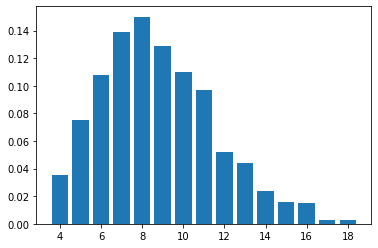

In [19]:
true_idx = 4 # Suppose the 4th prior sample is the true process.
discrete_distplot(prior_samples["x"][true_idx])

#### Posterior

In [20]:
mcmc = MCMC(DiscreteHMCGibbs(NUTS(truncated_poisson_model)), num_samples=1000, num_warmup=1000, num_chains=4)

In [21]:
mcmc.run(RNG, num_observations, prior_samples["x"][true_idx])

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [22]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       low      4.00      0.00      4.00      4.00      4.00       nan       nan
      rate      8.61      0.10      8.61      8.44      8.77   1315.09      1.00



## To do: Built in truncated distributions

The above sections shows you how to construct your own truncated distribution, but you don't have to reinvent the wheel. Numpyro has a bunch of truncated distributions already implemented...